<font color="red">注</font>: 使用 tensorboard 可视化需要安装 tensorflow (TensorBoard依赖于tensorflow库，可以任意安装tensorflow的gpu/cpu版本)

```shell
pip install tensorflow-cpu
```

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42


sys.version_info(major=3, minor=10, micro=14, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


## 数据准备

```shell
$ tree -L 1 cifar-10                                    
cifar-10
├── sampleSubmission.csv
├── test
├── train
└── trainLabels.csv
```

In [10]:
!pip list|grep kaggle

kaggle                            1.6.17

[notice] A new release of pip is available: 23.3.2 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [11]:
!mkdir -p ~/.kaggle
!cp /mnt/workspace/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [15]:
!kaggle competitions download -c cifar-10 #下载比赛数据集

100%|███████████████████████████████████████▉| 715M/715M [01:03<00:00, 15.1MB/s]
100%|████████████████████████████████████████| 715M/715M [01:03<00:00, 11.8MB/s]


In [22]:
!ls /content/competitions/cifar-10/

cifar-10.zip


In [17]:
!unzip /content/competitions/cifar-10/cifar-10.zip

Archive:  /content/competitions/cifar-10/cifar-10.zip
  inflating: sampleSubmission.csv    
  inflating: test.7z                 
  inflating: train.7z                
  inflating: trainLabels.csv         


In [18]:
!ls

01-classification_model-cnn-Aliyun.ipynb	       data
02_classification_model-cnn-selu.ipynb		       kaggle.json
03_classification_model-separable_cnn.ipynb	       runs
04_10_monkeys_model_1_aliyun.ipynb		       sampleSubmission.csv
04_10_monkeys_model_2.ipynb			       test.7z
05_10_monkeys_model_2_resnet50_finetune_2aliyun.ipynb  train.7z
06_cifar10_model_2-aliyun.ipynb			       trainLabels.csv
checkpoints


In [20]:
!pip install py7zr

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 52.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 112.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 110.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.2 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [21]:
# （已注释掉的安装命令）安装py7zr库用于处理7z压缩文件
# %pip install py7zr

# 导入py7zr库中的必要模块（实际需要完整导入库）
import py7zr  # 正确导入应该是这行，但原代码中该行被注释

# 创建SevenZipFile对象，打开当前目录下的train.7z文件，以只读模式访问
a = py7zr.SevenZipFile(r'./train.7z','r')
#           │           │       │
#           │           │       └─ 打开模式：r表示读取（解压）
#           │           └─ 原始压缩文件路径（使用原始字符串避免转义）
#           └─ 7z文件处理器类

# 将压缩包内容全部解压到指定目录（注意路径使用原始字符串）
a.extractall(path=r'./competitions/cifar-10/')
#     │            └─ 目标解压路径（会自动创建不存在的目录）
#     └─ 解压全部内容的方法

# 显式关闭压缩文件句柄（推荐使用with语句自动管理）
a.close()

In [23]:
a =py7zr.SevenZipFile(r'./test.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

In [24]:
!ls competitions/cifar-10/train/ |wc -l  #wc -l统计数量

50000


In [25]:
!ls competitions/cifar-10/train/ |wc -l 

50000


In [26]:
from pathlib import Path

DATA_DIR = Path(".")
DATA_DIR1 =Path("competitions/cifar-10/")
train_lables_file = DATA_DIR / "trainLabels.csv"
test_csv_file = DATA_DIR / "sampleSubmission.csv" #测试集模板csv文件
train_folder = DATA_DIR1 / "train"
test_folder = DATA_DIR1 / "test"

#所有的类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

def parse_csv_file(filepath, folder): #filepath:csv文件路径，folder:图片所在文件夹
    """Parses csv files into (filename(path), label) format"""
    results = []
    #读取所有行
    with open(filepath, 'r') as f:
#         lines = f.readlines()  为什么加[1:]，可以试这个
        #第一行不需要，因为第一行是标题
        lines = f.readlines()[1:] 
    for line in lines:#依次去取每一行
        image_id, label_str = line.strip('\n').split(',') #图片id 和标签分离
        image_full_path = folder / f"{image_id}.png"
        results.append((image_full_path, label_str)) #得到对应图片的路径和分类
    return results

#解析对应的文件夹
train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)
#打印
import pprint
pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

[(PosixPath('competitions/cifar-10/train/1.png'), 'frog'),
 (PosixPath('competitions/cifar-10/train/2.png'), 'truck'),
 (PosixPath('competitions/cifar-10/train/3.png'), 'truck'),
 (PosixPath('competitions/cifar-10/train/4.png'), 'deer'),
 (PosixPath('competitions/cifar-10/train/5.png'), 'automobile')]
[(PosixPath('competitions/cifar-10/test/1.png'), 'cat'),
 (PosixPath('competitions/cifar-10/test/2.png'), 'cat'),
 (PosixPath('competitions/cifar-10/test/3.png'), 'cat'),
 (PosixPath('competitions/cifar-10/test/4.png'), 'cat'),
 (PosixPath('competitions/cifar-10/test/5.png'), 'cat')]
50000 300000


In [27]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000]) # 取前45000张图片作为训练集
valid_df = pd.DataFrame(train_labels_info[45000:]) # 取后5000张图片作为验证集
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

                            filepath       class
0  competitions/cifar-10/train/1.png        frog
1  competitions/cifar-10/train/2.png       truck
2  competitions/cifar-10/train/3.png       truck
3  competitions/cifar-10/train/4.png        deer
4  competitions/cifar-10/train/5.png  automobile
                                filepath       class
0  competitions/cifar-10/train/45001.png       horse
1  competitions/cifar-10/train/45002.png  automobile
2  competitions/cifar-10/train/45003.png        deer
3  competitions/cifar-10/train/45004.png  automobile
4  competitions/cifar-10/train/45005.png    airplane
                           filepath class
0  competitions/cifar-10/test/1.png   cat
1  competitions/cifar-10/test/2.png   cat
2  competitions/cifar-10/test/3.png   cat
3  competitions/cifar-10/test/4.png   cat
4  competitions/cifar-10/test/5.png   cat


In [28]:
from PIL import Image  # 导入PIL库的Image模块，用于打开和处理图像
from torch.utils.data import Dataset, DataLoader  # 从PyTorch中导入Dataset和DataLoader类
from torchvision import transforms  # 从torchvision库中导入transforms模块

# 自定义CIFAR-10数据集类，继承自PyTorch的Dataset类
class Cifar10Dataset(Dataset):
    # 定义一个字典，将模式（'train'、'eval'、'test'）映射到相应的数据帧
    df_map = {
        "train": train_df,  # 训练集数据帧
        "eval": valid_df,   # 验证集数据帧
        "test": test_df     # 测试集数据帧
    }
    # 创建一个字典，将类别名称映射到索引（例如，'airplane' -> 0）
    label_to_idx = {label: idx for idx, label in enumerate(class_names)}
    # 创建一个字典，将索引映射回类别名称（例如，0 -> 'airplane'）
    idx_to_label = {idx: label for idx, label in enumerate(class_names)}

    def __init__(self, mode, transform=None):
        """
        初始化Cifar10Dataset类的实例。

        参数:
        mode (str): 数据集模式，应为 'train'、'eval' 或 'test' 之一。
        transform (callable, optional): 对图像应用的变换操作。
        """
        # 根据提供的模式从df_map字典中获取相应的数据帧
        self.df = self.df_map.get(mode, None)
        # 如果提供的模式无效，抛出一个ValueError
        if self.df is None:
            raise ValueError("mode should be one of 'train', 'eval', 'test', but got {}".format(mode))
        self.transform = transform  # 设置图像变换

    def __getitem__(self, index):
        """
        获取数据集中指定索引的样本。

        参数:
        index (int): 样本的索引。

        返回:
        tuple: 包含图像和对应标签的元组。
        """
        # 从数据帧中获取指定索引的图像路径和标签
        img_path, label = self.df.iloc[index]
        # 打开图像并转换为RGB模式
        img = Image.open(img_path).convert('RGB')
        # 如果定义了变换操作，则对图像应用变换
        if self.transform:
            img = self.transform(img)
        # 将标签从类别名称转换为对应的索引
        label = self.label_to_idx[label]
        return img, label  # 返回图像和标签

    def __len__(self):
        """
        返回数据集的大小。

        返回:
        int: 数据集中的样本数量。
        """
        return len(self.df)  # 返回数据帧的行数，即样本数量

# 定义图像的目标大小
IMAGE_SIZE = 32
# 定义CIFAR-10数据集的均值和标准差，用于图像标准化
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

# 定义训练集的图像变换操作
transforms_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # 调整图像大小
    transforms.RandomRotation(40),  # 随机旋转图像，旋转角度在40度以内
    transforms.RandomHorizontalFlip(),  # 随机水平翻转图像
    transforms.ToTensor(),  # 将图像转换为PyTorch张量，并将像素值缩放到[0, 1]范围
    # transforms.Normalize(mean, std)  # 使用预定义的均值和标准差对图像进行标准化
])

# 定义验证集和测试集的图像变换操作
transforms_eval = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # 调整图像大小
    transforms.ToTensor(),  # 将图像转换为PyTorch张量
    # transforms.Normalize(mean, std)  # 对图像进行标准化
])

# 创建训练集和验证集的数据集实例
train_ds = Cifar10Dataset("train", transforms_train)  # 训练集
eval_ds = Cifar10Dataset("eval", transforms_eval)     # 验证集


In [29]:
train_ds[0][1]

6

In [30]:
sample1=train_ds[0][0]
np.sum(sample1[2].numpy())

257.15295

In [31]:
print(train_ds.idx_to_label)  # 类别映射为idx
train_ds.label_to_idx # idx映射为类别

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [32]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)   
eval_dl = DataLoader(eval_ds, batch_size=batch_size, shuffle=False)

In [33]:
# 遍历train_ds得到每张图片，计算每个通道的均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std

# 经过 normalize 后 均值为0，方差为1
print(cal_mean_std(train_ds))

(tensor([0.4368, 0.4267, 0.3947]), tensor([0.2465, 0.2419, 0.2359]))


## 定义模型

In [34]:
# 导入必要的PyTorch模块
import torch.nn as nn
import numpy as np

# 定义一个卷积神经网络（CNN）类，继承自nn.Module
class CNN(nn.Module):
    def __init__(self, num_classes):
        """
        初始化CNN模型
        :param num_classes: 分类的类别数量
        """
        super().__init__()  # 调用父类nn.Module的初始化方法
        
        # 使用 nn.Sequential 方便地构建深度神经网络
        self.model = nn.Sequential(
            # 第一层卷积：输入通道3（RGB图像），输出通道128，卷积核大小3x3，保持输入大小不变（padding="same"）
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding="same"),
            nn.ReLU(),  # 激活函数ReLU，增加非线性表达能力
            nn.BatchNorm2d(128),  # 批标准化，减少内部协变量偏移，提高训练稳定性
            
            # 第二层卷积：输入通道128，输出通道128，卷积核大小3x3，保持输入大小不变
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            # 第一层池化：最大池化，窗口大小2x2，减少特征图尺寸（从32x32 -> 16x16）
            nn.MaxPool2d(kernel_size=2),
            
            # 第三层卷积：输入通道128，输出通道256，卷积核3x3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            
            # 第四层卷积：输入通道256，输出通道256，卷积核3x3
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            
            # 第二层池化：最大池化，窗口大小2x2，减少特征图尺寸（16x16 -> 8x8）
            nn.MaxPool2d(kernel_size=2),
            
            # 第五层卷积：输入通道256，输出通道512，卷积核3x3
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            
            # 第六层卷积：输入通道512，输出通道512，卷积核3x3
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            
            # 第三层池化：最大池化，窗口大小2x2，减少特征图尺寸（8x8 -> 4x4）
            nn.MaxPool2d(kernel_size=2),
            
            # 展平（Flatten）：将多维特征图展开为一维向量（4x4x512 = 8192）
            nn.Flatten(),
            
            # 全连接层：输入8192维，输出512维
            nn.Linear(8192, 512),
            nn.ReLU(),  # ReLU激活
            
            # 输出层：输入512维，输出num_classes（分类类别数）
            nn.Linear(512, num_classes),
        )
        
    # 定义前向传播
    def forward(self, x):
        return self.model(x)

# 计算模型参数的数量并打印
for key, value in CNN(len(class_names)).named_parameters():
    print(f"{key:^40} parameters num: {np.prod(value.shape)}")


             model.0.weight              parameters num: 3456
              model.0.bias               parameters num: 128
             model.2.weight              parameters num: 128
              model.2.bias               parameters num: 128
             model.3.weight              parameters num: 147456
              model.3.bias               parameters num: 128
             model.5.weight              parameters num: 128
              model.5.bias               parameters num: 128
             model.7.weight              parameters num: 294912
              model.7.bias               parameters num: 256
             model.9.weight              parameters num: 256
              model.9.bias               parameters num: 256
            model.10.weight              parameters num: 589824
             model.10.bias               parameters num: 256
            model.12.weight              parameters num: 256
             model.12.bias               parameters num: 256
            mo

In [35]:
total_params = sum(p.numel() for p in CNN(len(class_names)).parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 8779914


In [36]:
512*4*4

8192

In [37]:
input_4d = torch.randn(32, 3, 64, 64)  # 32 个样本，3 个通道，图像大小为 64x64
bn2d = nn.BatchNorm2d(3)              # 对 3 个通道进行归一化
output_4d = bn2d(input_4d)
output_4d.shape

torch.Size([32, 3, 64, 64])

In [38]:
output_4d

tensor([[[[ 3.0452e+00,  9.8681e-01, -1.3388e+00,  ...,  6.2809e-01,
            7.1609e-01, -1.6249e+00],
          [-6.4687e-01, -4.2207e-01,  1.7411e+00,  ..., -6.3522e-01,
           -1.3146e-01, -1.9065e-01],
          [-6.2807e-01,  1.4529e+00,  1.3066e-01,  ...,  5.9983e-01,
            2.1537e-01, -8.7821e-01],
          ...,
          [-1.3034e+00, -2.2394e-01, -1.8260e+00,  ...,  3.2911e-01,
            8.9360e-01, -7.0635e-01],
          [-5.5126e-01,  3.7809e-01, -9.9392e-01,  ..., -3.6580e-01,
           -1.1980e+00,  5.8600e-01],
          [-2.6598e-01,  2.7598e-01, -1.8594e-01,  ...,  3.8669e-02,
            2.2435e+00,  9.4962e-01]],

         [[-2.1068e-01, -4.3416e-01, -1.8338e+00,  ...,  4.3888e-01,
            1.6527e+00,  1.5573e-01],
          [-7.0490e-01,  1.0583e+00,  6.3417e-01,  ...,  7.5648e-01,
           -1.0947e+00, -4.2657e-03],
          [ 7.2850e-01, -1.4784e-01,  8.5122e-01,  ...,  4.8622e-01,
            7.4416e-01,  1.2872e+00],
          ...,
     

In [39]:
bn2d = nn.BatchNorm2d(1)              # 对 3 个通道进行归一化
output_4d1 = bn2d(input_4d[:, 0:1, :, :])
output_4d1

tensor([[[[ 3.0452e+00,  9.8681e-01, -1.3388e+00,  ...,  6.2809e-01,
            7.1609e-01, -1.6249e+00],
          [-6.4687e-01, -4.2207e-01,  1.7411e+00,  ..., -6.3522e-01,
           -1.3146e-01, -1.9065e-01],
          [-6.2807e-01,  1.4529e+00,  1.3066e-01,  ...,  5.9983e-01,
            2.1537e-01, -8.7821e-01],
          ...,
          [-1.3034e+00, -2.2394e-01, -1.8260e+00,  ...,  3.2911e-01,
            8.9360e-01, -7.0635e-01],
          [-5.5126e-01,  3.7809e-01, -9.9392e-01,  ..., -3.6580e-01,
           -1.1980e+00,  5.8600e-01],
          [-2.6598e-01,  2.7598e-01, -1.8594e-01,  ...,  3.8669e-02,
            2.2435e+00,  9.4962e-01]]],


        [[[ 1.4927e+00,  1.9575e+00,  6.7164e-01,  ..., -2.5171e-01,
           -8.7328e-01, -1.2085e+00],
          [-1.0297e-01,  9.1488e-01,  2.8130e-01,  ..., -5.6404e-01,
           -2.4521e-01,  1.4776e+00],
          [-2.3556e+00,  1.6856e-01, -1.7630e+00,  ...,  6.1955e-01,
           -1.2906e-01, -1.1866e+00],
          ...,
   

## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [40]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())
        
        preds = logits.argmax(axis=-1)    # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc


### TensorBoard 可视化


训练过程中可以使用如下命令启动tensorboard服务。

```shell
tensorboard \
    --logdir=runs \     # log 存放路径
    --host 0.0.0.0 \    # ip
    --port 8848         # 端口
```

In [41]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))
        
    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss", 
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )
        
    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )
        
    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
            
        )
    
    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


### Save Best


In [42]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



### Early Stop

In [43]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [44]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1) #最大值的索引
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())     # 计算准确率
                loss = loss.cpu().item() # 计算损失
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step # 记录每一步的损失和准确率
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()
                    
                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step, 
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                            )
                
                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 20

model = CNN(num_classes=10)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
# tensorboard_callback = TensorBoardCallback("runs/cifar-10")
# tensorboard_callback.draw_model(model, [1, 3, IMAGE_SIZE, IMAGE_SIZE])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/cifar-10", save_step=len(train_dl), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

model = model.to(device)


In [45]:
record = training(
    model,
    train_dl,
    eval_dl,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)
    )

100%|██████████| 14080/14080 [09:21<00:00, 25.09it/s, epoch=19]


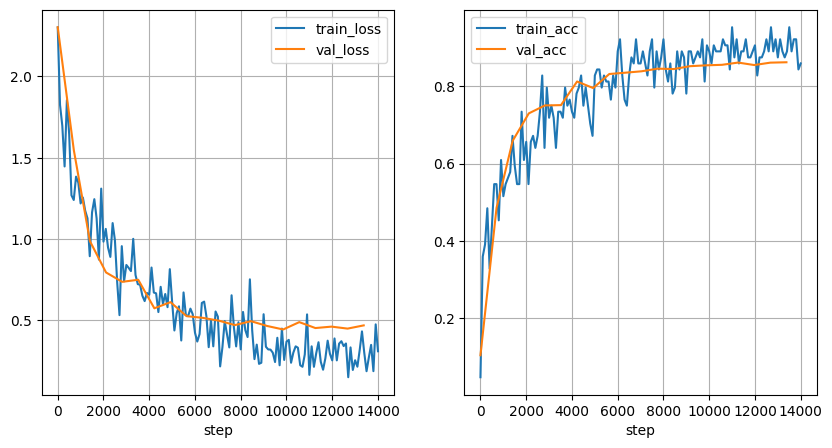

In [56]:
# 画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):    
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record, sample_step=100)  #横坐标是 steps

# 评估

In [47]:
# dataload for evaluating
# load checkpoints
model.load_state_dict(torch.load("checkpoints/cifar-10/best.ckpt", map_location="cpu"))

model.eval()
loss, acc = evaluating(model, eval_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

/tmp/ipykernel_2373/4227932207.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/cifar-10/best.ckpt", map_location="cpu"))


loss:     0.4692
accuracy: 0.8624


# 推理

In [48]:
# test_df
test_ds = Cifar10Dataset("test", transform=transforms_eval)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

preds_collect = [] # 预测结果收集器
model.eval()
for data, fake_label in tqdm(test_dl):
    data = data.to(device=device)
    logits = model(data) #得到预测结果
    preds = [test_ds.idx_to_label[idx] for idx in logits.argmax(axis=-1).cpu().tolist()] # 得到预测类别，idx_to_label是id到字符串类别的映射
    preds_collect.extend(preds)
    


100%|██████████| 4688/4688 [01:38<00:00, 47.45it/s]


In [49]:
test_df.head()

,filepath,class
0,competitions/cifar-10/test/1.png,cat
1,competitions/cifar-10/test/2.png,cat
2,competitions/cifar-10/test/3.png,cat
3,competitions/cifar-10/test/4.png,cat
4,competitions/cifar-10/test/5.png,cat


In [50]:
test_df1 = pd.DataFrame(list(range(1,3*10**5+1)), columns=["id"])
test_df1

,id
0,1
1,2
2,3
3,4
4,5
...,...
299995,299996
299996,299997
299997,299998
299998,299999


In [51]:
test_df1["label"] = preds_collect # 增加预测类别列,比赛要求这一列是label
test_df1.head()

,id,label
0,1,deer
1,2,airplane
2,3,automobile
3,4,ship
4,5,airplane


In [52]:
# 导出 submission.csv
test_df1.to_csv("submission.csv", index=False)

In [53]:
!ls checkpoints/

cifar-10  cnn-relu  cnn-selu  dsc-selu	monkeys-cnn-relu  monkeys-resnet50
